**Simple example of transfer learning from pretrained model using Keras.**
* Loss: Focal loss
* Metrics: f2_score

In [65]:
import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Activation, Dropout, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers, applications
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from keras import backend as K 

In [66]:
train_df = pd.read_csv("../input/train.csv")
train_df["attribute_ids"]=train_df["attribute_ids"].apply(lambda x:x.split(" "))
train_df["id"]=train_df["id"].apply(lambda x:x+".png")
train_df.head()

,id,attribute_ids
0,1000483014d91860.png,"[147, 616, 813]"
1,1000fe2e667721fe.png,"[51, 616, 734, 813]"
2,1001614cb89646ee.png,[776]
3,10041eb49b297c08.png,"[51, 671, 698, 813, 1092]"
4,100501c227f8beea.png,"[13, 404, 492, 903, 1093]"


In [67]:
label_df = pd.read_csv("../input/labels.csv")
print(label_df.shape)
label_df.head()

(1103, 2)


,attribute_id,attribute_name
0,0,culture::abruzzi
1,1,culture::achaemenid
2,2,culture::aegean
3,3,culture::afghan
4,4,culture::after british


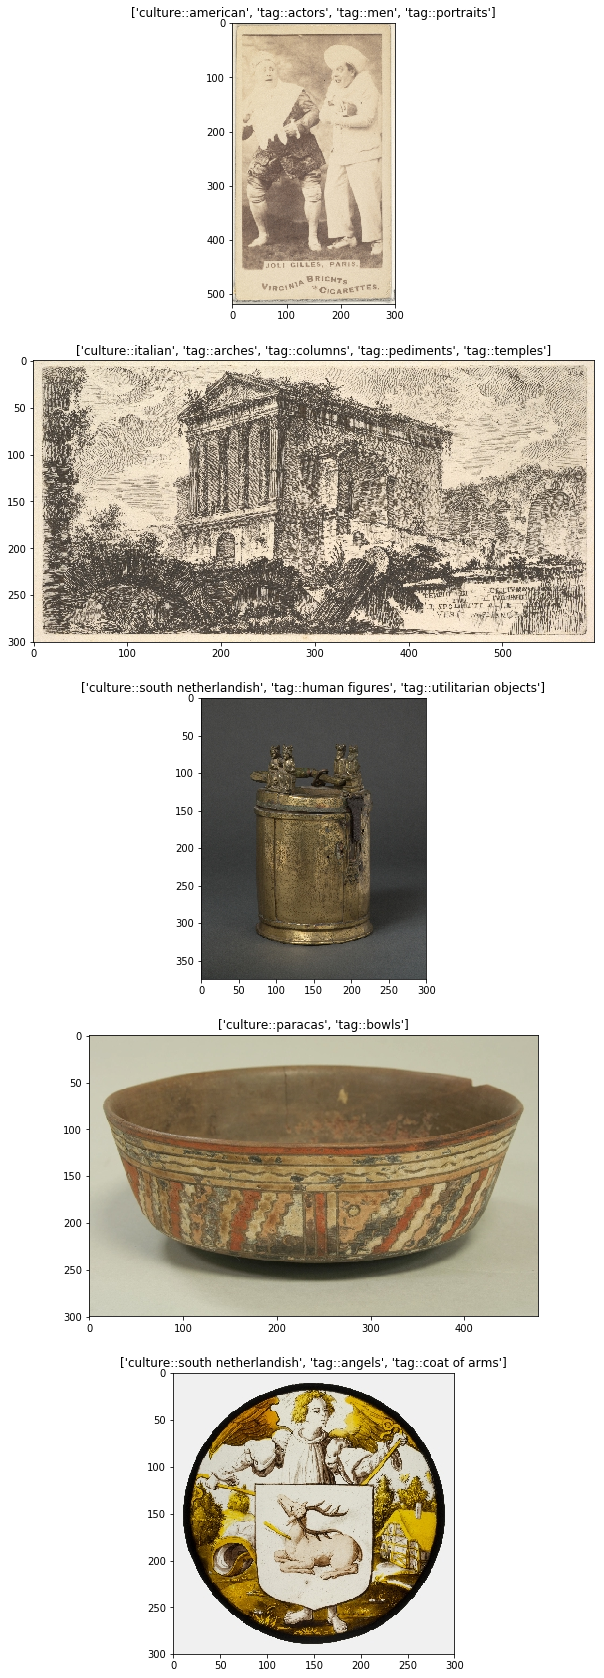

In [68]:
# Example of images with tags

i = 1
plt.figure(figsize=[30,30])
for img_name in os.listdir("../input/train/")[5:10]:   
    img = cv2.imread("../input/train/%s" % img_name)[...,[2, 1, 0]]
    plt.subplot(5, 1, i)
    plt.imshow(img)
    ids = train_df[train_df["id"] == img_name]["attribute_ids"]
    title_val = []
    for tag_id in ids.values[0]:
        att_name = label_df[label_df['attribute_id'].astype(str) == tag_id]['attribute_name'].values[0]
        title_val.append(att_name)
    plt.title(title_val)
    i += 1
    
plt.show()

In [93]:
nb_classes = 1103
batch_size = 96
img_size = 224
nb_epochs = 30

In [70]:
lbls = list(map(str, range(nb_classes)))

In [71]:
%%time

train_datagen=ImageDataGenerator(
    rescale=1./255, 
    validation_split=0.25,
    horizontal_flip = True,    
    zoom_range = 0.3,
    width_shift_range = 0.3,
    height_shift_range=0.3
    )

train_generator=train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory="../input/train",
    x_col="id",
    y_col="attribute_ids",
    batch_size=batch_size,
    shuffle=True,
    class_mode="categorical",
    classes=lbls,
    target_size=(img_size,img_size),
    subset='training')

valid_generator=train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory="../input/train",
    x_col="id",
    y_col="attribute_ids",
    batch_size=batch_size,
    shuffle=True,
    class_mode="categorical",    
    classes=lbls,
    target_size=(img_size,img_size),
    subset='validation')

Found 81928 images belonging to 1103 classes.
Found 27309 images belonging to 1103 classes.
CPU times: user 2.53 s, sys: 3.86 s, total: 6.39 s
Wall time: 21.7 s


In [72]:
# Loss

gamma = 2.0
epsilon = K.epsilon()
def focal_loss(y_true, y_pred):
    pt = y_pred * y_true + (1-y_pred) * (1-y_true)
    pt = K.clip(pt, epsilon, 1-epsilon)
    CE = -K.log(pt)
    FL = K.pow(1-pt, gamma) * CE
    loss = K.sum(FL, axis=1)
    return loss

In [73]:
# Metric

def f2_score(y_true, y_pred):
    beta = 2
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=1)
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)), axis=1)
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)), axis=1)
    
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    
    return K.mean(((1+beta**2)*precision*recall) / ((beta**2)*precision+recall+K.epsilon()))

In [80]:
model = applications.VGG16(weights=None, 
                          include_top=False, 
                          input_shape=(img_size, img_size, 3))
# model.load_weights('../input/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5')

In [91]:
# Freeze some layers
for layer in model.layers[:-4]:
    layer.trainable = True

In [82]:
#Adding custom layers 
x = model.output
x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
predictions = Dense(nb_classes, activation="softmax")(x)
model_final = Model(input = model.input, output = predictions)

model_final.compile(optimizers.rmsprop(lr=0.0001, decay=1e-6),loss=focal_loss,metrics=[f2_score])

/home/sano/.pyenv/versions/anaconda3-5.3.1/envs/deep/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  import sys


In [83]:
# model_final.summary()

In [84]:
# Callbacks

checkpoint = ModelCheckpoint("vgg16_1.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')

In [92]:
%%time
history = model_final.fit_generator(generator=train_generator,                   
                                    steps_per_epoch=500,
                                    validation_data=valid_generator,                    
                                    validation_steps=200,
                                    epochs=nb_epochs,
                                    callbacks = [checkpoint, early],
                                    verbose=0)

/home/sano/.pyenv/versions/anaconda3-5.3.1/envs/deep/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'



Epoch 00001: val_loss improved from inf to 16.35310, saving model to vgg16_1.h5

Epoch 00002: val_loss improved from 16.35310 to 16.30876, saving model to vgg16_1.h5

Epoch 00003: val_loss improved from 16.30876 to 15.70169, saving model to vgg16_1.h5
CPU times: user 1h 36min 59s, sys: 2h 28min 11s, total: 4h 5min 11s
Wall time: 41min 18s


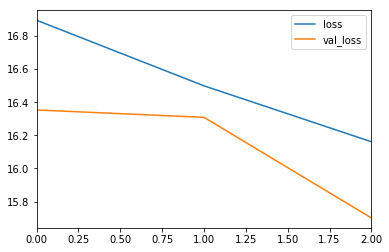

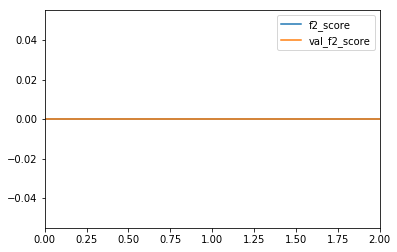

In [94]:
with open('history.json', 'w') as f:
    json.dump(history.history, f)

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['f2_score', 'val_f2_score']].plot()

In [95]:
sam_sub_df = pd.read_csv('../input/sample_submission.csv')
sam_sub_df["id"]=sam_sub_df["id"].apply(lambda x:x+".png")
print(sam_sub_df.shape)
sam_sub_df.head()

(7443, 2)


,id,attribute_ids
0,10023b2cc4ed5f68.png,0 1 2
1,100fbe75ed8fd887.png,0 1 2
2,101b627524a04f19.png,0 1 2
3,10234480c41284c6.png,0 1 2
4,1023b0e2636dcea8.png,0 1 2


In [96]:
%%time
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(  
        dataframe=sam_sub_df,
        directory = "../input/imet-2019-fgvc6/test",    
        x_col="id",
        target_size = (img_size,img_size),
        batch_size = 1,
        shuffle = False,
        class_mode = None
        )

Found 0 images.
CPU times: user 44.6 ms, sys: 0 ns, total: 44.6 ms
Wall time: 43 ms


In [97]:
%%time
test_generator.reset()
predict = model_final.predict_generator(test_generator, steps = len(test_generator.filenames))

CPU times: user 4.71 ms, sys: 0 ns, total: 4.71 ms
Wall time: 3.65 ms


In [98]:
len(predict)

0

In [99]:
%%time
import operator
predicted_class_indices_3=[]
for i in range(len(predict)):         
    d = {}
    for index, value in enumerate(predict[i]):               
        if value > 0.04:            
            d[index] = value 
    sorted_d = sorted(d.items(), key=operator.itemgetter(1), reverse=True)
    
    # Take only first 7 items
    predicted_class_indices_3.append([i[0] for i in sorted_d[:7]])

CPU times: user 17 µs, sys: 0 ns, total: 17 µs
Wall time: 26.7 µs


In [22]:
%%time
predictions_3=[]

for i in range(len(predicted_class_indices_3)):
    labels = (train_generator.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    predictions = [labels[k] for k in predicted_class_indices_3[i]]
    predictions_3.append(predictions)

CPU times: user 1.32 s, sys: 0 ns, total: 1.32 s
Wall time: 1.32 s


In [23]:
predict_3 = []
for i in range(len(predictions_3)):
    str3 = " ".join(predictions_3[i])
    predict_3.append(str3)

In [24]:
filenames=test_generator.filenames
results=pd.DataFrame({"id":filenames,
                      "attribute_ids":predict_3})
results['id'] = results['id'].map(lambda x: str(x)[:-4])
results.to_csv("submission.csv",index=False)

In [25]:
results.head()

,id,attribute_ids
0,10023b2cc4ed5f68,587 766 369 1059
1,100fbe75ed8fd887,1039 188 231 489 1085 121 464
2,101b627524a04f19,498
3,10234480c41284c6,1046 776 813 51 147 483 738
4,1023b0e2636dcea8,813 1092 612 156 147 671
